# Clustering networks

In [45]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log
_log.setLevel('ERROR')

from collections import Counter
from hdbscan import HDBSCAN
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering, k_means, spectral_clustering
from matplotlib.cm import get_cmap
from sklearn.manifold import spectral_embedding
from sklearn.utils import check_array
%matplotlib inline

seed = 42
random_state = np.random.RandomState(seed)

Defining the network:

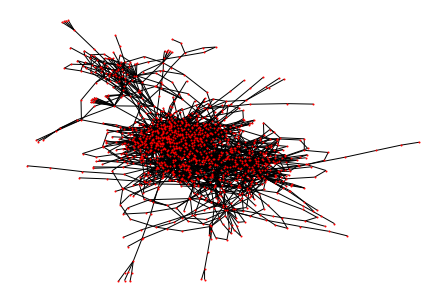

In [46]:
# G = nx.Graph()
# G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'])
# G.add_edges_from([
#     ('A', 'B'), ('A', 'C'), ('A', 'D'), ('A', 'E'), ('B', 'C'), ('B', 'F'), ('C', 'F'), ('D', 'G'), ('D', 'H'),
#     ('E', 'H'), ('F', 'I'), ('G', 'I'), ('G', 'J'), ('H', 'J'), ('I', 'K'), ('J', 'K'),
# ])
# G = nx.erdos_renyi_graph(50, .08, seed=seed)
G = nx.read_edgelist("air_traffic.edgelist")

pos_fr = nx.fruchterman_reingold_layout(G, seed=seed)
# pos_fr = nx.spectral_layout(G)

nx.draw(G, pos=pos_fr, node_size=1, node_color='red', with_labels=False)
plt.show()

Reducing dimensions with spectral embedding and clustering with HDBSCAN:

clusters: 3
noise: 0.126


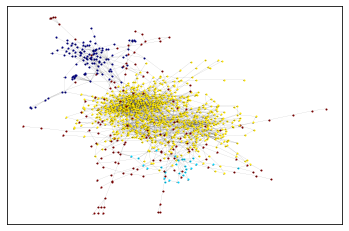

In [47]:
adj_matrix = nx.to_numpy_matrix(G)
node_list = list(G.nodes()) 

# clusters = SpectralClustering(
#     affinity='precomputed', assign_labels='kmeans', random_state=random_state, n_clusters=3
# ).fit_predict(adj_matrix)
adj_matrix = check_array(adj_matrix, accept_sparse=['csr', 'csc', 'coo'], dtype=np.float64, ensure_min_samples=2)
maps = spectral_embedding(adj_matrix, n_components=10, random_state=random_state, drop_first=False)
# _, clusters, _ = k_means(maps, n_clusters=5, random_state=random_state, n_init=10)
clusters = HDBSCAN(
    min_samples=5,
    min_cluster_size=20
).fit_predict(maps)

print(f"clusters: {np.amax(clusters) + 1}")
print(f"noise: {np.round(Counter(clusters)[-1] / len(clusters), 3)}")

cmap = get_cmap('jet')(np.linspace(0, 1.0, np.amax(clusters) + 2))

for i in range(len(node_list)):
    nx.draw_networkx_nodes(G, pos=pos_fr, nodelist={node_list[i]}, node_size=1, node_color=cmap[clusters[i]])
nx.draw_networkx_edges(G, pos=pos_fr, width=.05)
nx.draw_networkx_labels(G, pos=pos_fr, font_size=1)
plt.savefig("graph.pdf")
plt.show()

Removing nodes labeled as noise by HDBSCAN:

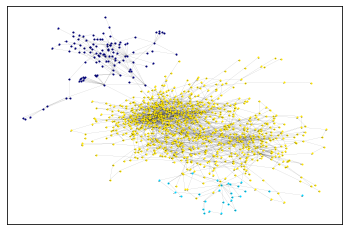

In [48]:
G.remove_nodes_from([node_list[i] for i in range(len(node_list)) if clusters[i] == -1])
node_list = list(G.nodes())
clusters = [clusters[i] for i in range(len(clusters)) if clusters[i] != -1]

for i in range(len(node_list)):
    nx.draw_networkx_nodes(G, pos=pos_fr, nodelist={node_list[i]}, node_size=1, node_color=cmap[clusters[i]])
nx.draw_networkx_edges(G, pos=pos_fr, width=.05)
nx.draw_networkx_labels(G, pos=pos_fr, font_size=1)
plt.savefig("graph2.pdf")